<a href="https://colab.research.google.com/github/LNshuti/eactrade/blob/main/ec_trade_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
!pip install networkx --quiet
!pip install python-louvain --quiet
!pip install scipy --quiet

In [29]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from community import community_louvain
import seaborn as sns
import scipy

# Load your data. Load the parquet file
df = pd.read_parquet('processed\country_partner_sitcproduct4digit_year_2021.parquet')
df

,location_id,partner_id,product_id,year,export_value,import_value,sitc_eci,sitc_coi,location_code,partner_code,sitc_product_code
0,0,7,669,2021.0,13476.0,0.0,1.081984,-0.220936,ABW,ARE,0224
1,1,7,669,2021.0,0.0,581022.0,-1.014010,-0.643190,AFG,ARE,0224
2,2,7,669,2021.0,0.0,6251545.0,-1.040071,-1.115572,AGO,ARE,0224
3,8,7,669,2021.0,4966652.0,1096910.0,-0.197862,0.138124,ARG,ARE,0224
4,9,7,669,2021.0,0.0,7555.0,-0.519808,-0.827174,ARM,ARE,0224
...,...,...,...,...,...,...,...,...,...,...,...
4173745,43,239,838,2021.0,0.0,1135435.0,1.327020,0.191976,CHN,VNM,2860
4173746,186,239,838,2021.0,5096915.0,139691.0,0.192385,0.634911,RUS,VNM,2860
4173747,39,157,838,2021.0,0.0,21217960.0,0.578854,1.445207,CAN,NER,2860
4173748,77,157,838,2021.0,0.0,17648098.0,1.336221,0.634767,FRA,NER,2860


In [30]:
df.columns

Index(['location_id', 'partner_id', 'product_id', 'year', 'export_value',
       'import_value', 'sitc_eci', 'sitc_coi', 'location_code', 'partner_code',
       'sitc_product_code'],
      dtype='object')

In [31]:
# Calculate total imports for each location
node_sizes = df.groupby(['product_id', 'location_code', 'partner_code'])['import_value'].sum().to_dict()
# Filter nodes to only include those with > 0
node_sizes = {k: v for k, v in node_sizes.items() if v > 200009683}
node_sizes

{(650, 'CAN', 'USA'): 360519456.0,
 (650, 'CHN', 'AUS'): 240005248.0,
 (650, 'CHN', 'NZL'): 235036256.0,
 (650, 'ESP', 'FRA'): 208712832.0,
 (650, 'IDN', 'AUS'): 471425152.0,
 (650, 'ITA', 'FRA'): 1185010816.0,
 (650, 'USA', 'CAN'): 879072640.0,
 (650, 'USA', 'MEX'): 662069056.0,
 (650, 'VNM', 'AUS'): 247231648.0,
 (651, 'SAU', 'SDN'): 228206048.0,
 (652, 'DEU', 'DNK'): 388744896.0,
 (652, 'DEU', 'NLD'): 311584064.0,
 (652, 'HKG', 'CHN'): 395239200.0,
 (652, 'POL', 'DNK'): 319293024.0,
 (652, 'USA', 'CAN'): 569463296.0,
 (653, 'NLD', 'DEU'): 414974688.0,
 (654, 'CHN', 'HKG'): 644150272.0,
 (654, 'GBR', 'IRL'): 348978944.0,
 (654, 'HKG', 'CHN'): 667396672.0,
 (654, 'IRL', 'GBR'): 379682080.0,
 (656, 'ARE', 'BRA'): 202056880.0,
 (656, 'CAN', 'USA'): 572579520.0,
 (656, 'CHL', 'ARG'): 211553600.0,
 (656, 'CHL', 'BRA'): 565657728.0,
 (656, 'CHL', 'PRY'): 720655296.0,
 (656, 'CHN', 'ARG'): 1767583232.0,
 (656, 'CHN', 'AUS'): 1132953856.0,
 (656, 'CHN', 'BRA'): 4232309248.0,
 (656, 'CHN', 'N

In [32]:
# Calculate total imports for each name and partner, and keep top 10
top_10_imports = df.groupby(['product_id', 'partner_code'])['import_value'].sum().nlargest(10).to_dict()
top_10_imports

In [ ]:
# Create a directed graph, filtering for top 10
G = nx.from_pandas_edgelist(df[df.apply(lambda row: (row['product_id'], row['partner_code']) in top_10_imports, axis=1)],
                           'product_id', 'partner_code', edge_attr='import_value', create_using=nx.DiGraph())
G.nodes()

NodeView((1273, 'CHN', 1286, 1307, 'KOR', 'TWN', 1314, 'DEU', 865, 'SAU', 1437, 'ARE', 'HKG', 'ANS'))

In [ ]:
G.edges()

OutEdgeView([(1273, 'CHN'), (1286, 'CHN'), (1307, 'CHN'), (1307, 'KOR'), (1307, 'TWN'), (1314, 'DEU'), (865, 'SAU'), (1437, 'ARE'), (1437, 'HKG'), (1437, 'ANS')])

In [ ]:
def load_data(file_path):
    """
    Load the dataset from a parquet file.

    Args:
    file_path (str): The path to the parquet file.

    Returns:
    pd.DataFrame: The loaded dataframe.
    """
    return pd.read_parquet(file_path)

def format_currency(x, pos):
    """
    Format the value as currency with commas and a dollar sign.

    Args:
    x (float): The value to format.
    pos (int): Position index (required for the formatter but not used here).

    Returns:
    str: The formatted string.
    """
    return f"${x:,.0f}"

def filter_data(df):
    """
    Filter the necessary columns from the dataframe.

    Args:
    df (pd.DataFrame): The input dataframe.

    Returns:
    pd.DataFrame: The filtered dataframe.
    """
    return df[['product_id', 'export_value', 'import_value', 'year',
               'sitc_eci', 'sitc_coi', 'location_code', 'partner_code',
               'sitc_product_code']]

def create_network_graph(df):
    """
    Create a directed network graph from the dataframe.

    Args:
    df (pd.DataFrame): The filtered dataframe.

    Returns:
    nx.DiGraph: The created network graph.
    """
    G = nx.DiGraph()

    for index, row in df.iterrows():
        product = row['product_id']
        partner_id = row['partner_code']
        import_value = row['import_value']

        # Add nodes and weighted edges
        G.add_node(product)
        G.add_node(partner_id)
        G.add_edge(product, partner_id, weight=import_value, label='imports')

    return G


def plot_network_graph(G, partition=None):
    """
    Plot the network graph.

    Args:
    G (nx.DiGraph): The network graph to be plotted.
    partition (dict, optional): The partition of the graph for community detection.
    """
    pos = nx.spring_layout(G)
    plt.figure(figsize=(12, 12))

    if partition:
        colors = [partition[node] for node in G.nodes()]
        nx.draw_networkx_nodes(G, pos, node_size=7000, node_color=colors, cmap=plt.cm.rainbow)
    else:
        nx.draw_networkx_nodes(G, pos, node_size=7000)

    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

    edge_labels = {(u, v): f"{d['label']} ({d['weight']})" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=20)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    plt.title("Comprehensive Network Analysis")
    plt.show()

def calculate_network_statistics(G):
    """
    Calculate and return network statistics.

    Args:
    G (nx.DiGraph): The network graph.

    Returns:
    dict: A dictionary containing network statistics.
    """
    stats = {
        'number_of_nodes': G.number_of_nodes(),
        'number_of_edges': G.number_of_edges(),
        'average_clustering': nx.average_clustering(G),
        'average_shortest_path_length': nx.average_shortest_path_length(G) if nx.is_connected(G.to_undirected()) else 'Graph is not connected',
        'density': nx.density(G)
    }
    return stats

def detect_communities(G):
    """
    Detect communities in the network graph using the Louvain method.

    Args:
    G (nx.DiGraph): The network graph.

    Returns:
    dict: A dictionary with nodes as keys and communities as values.
    """
    partition = community_louvain.best_partition(G.to_undirected())
    return partition

def plot_import_heatmap(df):
    """
    Plots a heatmap of import_value.

    Args:
        df (pd.DataFrame): The filtered dataframe.
    """
    import_matrix = df.pivot(index="product_id", columns="partner_code", values="import_value") # Updated pivot method syntax
    plt.figure(figsize=(14, 10))
    sns.heatmap(import_matrix, annot=True, fmt=".0f", cmap="YlGnBu")
    plt.title("Rwanda's Largest Imports by Partners in 2021")
    plt.xlabel("Partner Code")
    plt.ylabel("Product ID")

    plt.show()

In [ ]:
df_filtered = filter_data(df)
df_filtered

,product_id,export_value,import_value,sitc_eci,sitc_coi,location_code,partner_code,sitc_product_code
0,669,13476.0,0.0,1.081984,-0.220936,ABW,ARE,0224
1,669,0.0,581022.0,-1.014010,-0.643190,AFG,ARE,0224
2,669,0.0,6251545.0,-1.040071,-1.115572,AGO,ARE,0224
3,669,4966652.0,1096910.0,-0.197862,0.138124,ARG,ARE,0224
4,669,0.0,7555.0,-0.519808,-0.827174,ARM,ARE,0224
...,...,...,...,...,...,...,...,...
4173745,838,0.0,1135435.0,1.327020,0.191976,CHN,VNM,2860
4173746,838,5096915.0,139691.0,0.192385,0.634911,RUS,VNM,2860
4173747,838,0.0,21217960.0,0.578854,1.445207,CAN,NER,2860
4173748,838,0.0,17648098.0,1.336221,0.634767,FRA,NER,2860


In [10]:
# Filter out rows where both imports and exports are equal to zero
df_filtered = df_filtered[(df_filtered['import_value'] != 0) | (df_filtered['export_value'] != 0)]
df_filtered

,product_id,export_value,import_value,sitc_eci,sitc_coi,location_code,partner_code,sitc_product_code
0,669,13476.0,0.0,1.081984,-0.220936,ABW,ARE,0224
1,669,0.0,581022.0,-1.014010,-0.643190,AFG,ARE,0224
2,669,0.0,6251545.0,-1.040071,-1.115572,AGO,ARE,0224
3,669,4966652.0,1096910.0,-0.197862,0.138124,ARG,ARE,0224
4,669,0.0,7555.0,-0.519808,-0.827174,ARM,ARE,0224
...,...,...,...,...,...,...,...,...
4173745,838,0.0,1135435.0,1.327020,0.191976,CHN,VNM,2860
4173746,838,5096915.0,139691.0,0.192385,0.634911,RUS,VNM,2860
4173747,838,0.0,21217960.0,0.578854,1.445207,CAN,NER,2860
4173748,838,0.0,17648098.0,1.336221,0.634767,FRA,NER,2860


In [11]:
# Filter out rows where (if imports are equal to zero and exports less than 30000
# Or exports equal to zero and imorts less than 30000)
df_filtered = df_filtered[~(((df_filtered['import_value'] == 0) & (df_filtered['export_value'] < 180000000)) |
                           ((df_filtered['export_value'] == 0) & (df_filtered['import_value'] < 180000000)))]

df_filtered

,product_id,export_value,import_value,sitc_eci,sitc_coi,location_code,partner_code,sitc_product_code
3,669,4966652.0,1096910.0,-0.197862,0.138124,ARG,ARE,0224
5,669,27040060.0,142697.0,-0.549442,-0.412212,AUS,ARE,0224
6,669,114754.0,73401.0,1.675471,-0.331413,AUT,ARE,0224
8,669,11454609.0,259730.0,1.183627,1.186762,BEL,ARE,0224
10,669,10307.0,5237282.0,-0.762808,-1.036089,BGD,ARE,0224
...,...,...,...,...,...,...,...,...
4173457,652,43024.0,286415.0,-0.411196,-0.325374,LAO,KHM,0013
4173496,830,1848.0,82564.0,1.404903,0.672085,USA,CHN,2784
4173582,830,82564.0,1848.0,1.327020,0.191976,CHN,USA,2784
4173719,838,139691.0,5096915.0,0.036365,0.823911,VNM,RUS,2860


In [12]:
# Only keep Rwanda's data
df_filtered = df_filtered[df_filtered['location_code'] == 'RWA']
df_filtered

,product_id,export_value,import_value,sitc_eci,sitc_coi,location_code,partner_code,sitc_product_code
91,669,3869.0,4.490390e+05,-0.480913,-0.076801,RWA,ARE,0224
3944,669,18564.0,3.298000e+03,-0.480913,-0.076801,RWA,ZAF,0224
6161,669,6172.0,1.179000e+03,-0.480913,-0.076801,RWA,ZMB,0224
6982,732,732930.0,3.063400e+04,-0.480913,-0.076801,RWA,ARE,0741
7647,732,3381054.0,6.839000e+03,-0.480913,-0.076801,RWA,CHN,0741
...,...,...,...,...,...,...,...,...
4073497,786,2787.0,1.442000e+03,-0.480913,-0.076801,RWA,IND,2511
4074826,786,1830.0,1.001990e+05,-0.480913,-0.076801,RWA,KEN,2511
4075390,786,8934.0,1.719600e+04,-0.480913,-0.076801,RWA,TZA,2511
4118228,763,38097.0,6.509100e+04,-0.480913,-0.076801,RWA,KEN,2222


In [13]:
G = create_network_graph(df_filtered)
G.nodes()

NodeView((669, 'ARE', 'ZAF', 'ZMB', 732, 'CHN', 'IND', 'KEN', 'TZA', 743, 'BEL', 'GBR', 'USA', 'NGA', 'COD', 748, 'DEU', 753, 754, 948, 950, 968, 992, 'THA', 1032, 'NLD', 1112, 1160, 1169, 'GHA', 1180, 1181, 'BDI', 1182, 1193, 1198, 1261, 1273, 'CHE', 'FIN', 'IRL', 'ITA', 1277, 1286, 'AUT', 'FRA', 'ETH', 1291, 'ESP', 'HKG', 1294, 1299, 1307, 'MYS', 1321, 1373, 1408, 'SWE', 'EGY', 'MAR', 'UGA', 'VNM', 1432, 668, 670, 680, 685, 687, 690, 693, 696, 697, 698, 699, 701, 702, 703, 704, 705, 706, 714, 717, 719, 'CAN', 725, 726, 727, 731, 734, 735, 740, 745, 746, 747, 815, 'KOR', 833, 837, 854, 855, 858, 866, 'TUR', 'QAT', 872, 889, 'MWI', 893, 905, 926, 936, 939, 944, 946, 949, 951, 955, 959, 961, 976, 983, 986, 987, 1004, 1006, 1009, 1012, 1022, 1033, 1035, 1036, 1047, 1048, 1050, 1068, 1075, 1077, 1078, 1088, 1109, 1111, 1113, 1125, 1146, 1162, 1163, 1167, 1170, 1171, 1173, 1174, 1176, 1179, 1189, 1190, 1197, 1210, 1211, 1214, 1225, 1227, 1228, 1229, 1230, 1236, 1238, 1241, 1244, 'POL', 124

In [14]:
# Display the 10 most prominent edges
G.edges(data=True)

OutEdgeDataView([(669, 'ARE', {'weight': 449039.0, 'label': 'imports'}), (669, 'ZAF', {'weight': 3298.0, 'label': 'imports'}), (669, 'ZMB', {'weight': 1179.0, 'label': 'imports'}), (732, 'ARE', {'weight': 30634.0, 'label': 'imports'}), (732, 'CHN', {'weight': 6839.0, 'label': 'imports'}), (732, 'IND', {'weight': 1806.0, 'label': 'imports'}), (732, 'KEN', {'weight': 8963.0, 'label': 'imports'}), (732, 'TZA', {'weight': 59158.0, 'label': 'imports'}), (743, 'BEL', {'weight': 1843278.0, 'label': 'imports'}), (743, 'GBR', {'weight': 12650.0, 'label': 'imports'}), (743, 'USA', {'weight': 1214898.0, 'label': 'imports'}), (743, 'KEN', {'weight': 5524622.0, 'label': 'imports'}), (743, 'NGA', {'weight': 19775.0, 'label': 'imports'}), (743, 'COD', {'weight': 19000.0, 'label': 'imports'}), (743, 'TZA', {'weight': 1244323.0, 'label': 'imports'}), (748, 'ARE', {'weight': 400060.0, 'label': 'imports'}), (748, 'DEU', {'weight': 60254.0, 'label': 'imports'}), (748, 'USA', {'weight': 82021.0, 'label': '

In [15]:
#plot_network_graph(G)

In [16]:
partition = detect_communities(G)
#partition

In [17]:
#plot_network_graph(G, partition)

In [18]:
# Check for duplicates in the 'name' column
print(df_filtered['product_id'].duplicated().sum())

# 1. Drop duplicates:
df_filtered = df_filtered.drop_duplicates(subset=['product_id'])
df_filtered

424


,product_id,export_value,import_value,sitc_eci,sitc_coi,location_code,partner_code,sitc_product_code
91,669,3869.0,4.490390e+05,-0.480913,-0.076801,RWA,ARE,0224
6982,732,732930.0,3.063400e+04,-0.480913,-0.076801,RWA,ARE,0741
14235,743,2527.0,1.843278e+06,-0.480913,-0.076801,RWA,BEL,0980
28780,748,198751.0,4.000600e+05,-0.480913,-0.076801,RWA,ARE,1124
38000,753,32663.0,3.782200e+04,-0.480913,-0.076801,RWA,ARE,1222
...,...,...,...,...,...,...,...,...
3957897,952,114345.0,4.334400e+04,-0.480913,-0.076801,RWA,USA,5621
4050040,678,136259.0,2.228500e+04,-0.480913,-0.076801,RWA,COD,0350
4073497,786,2787.0,1.442000e+03,-0.480913,-0.076801,RWA,IND,2511
4118228,763,38097.0,6.509100e+04,-0.480913,-0.076801,RWA,KEN,2222


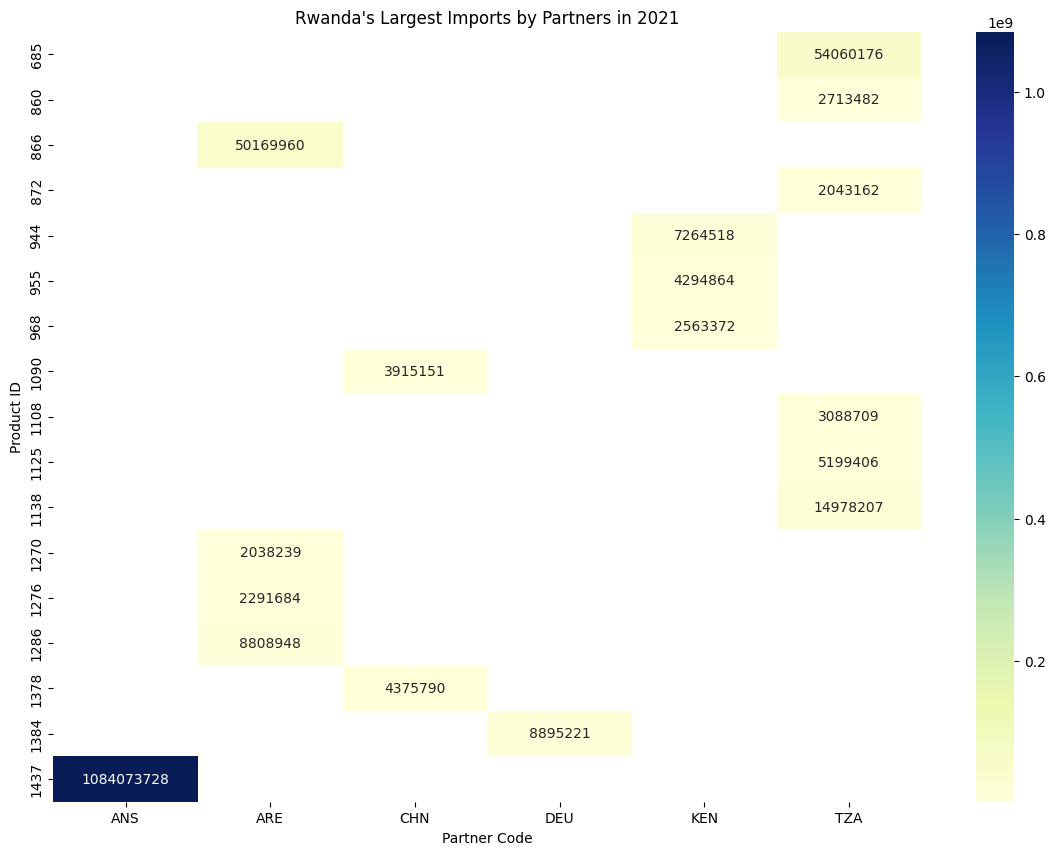

In [19]:
# 2. Aggregate duplicates (e.g., sum imports for the same name):
df_filtered = df_filtered.groupby('product_id').agg({'partner_code': 'first', 'import_value': 'sum'}).reset_index()

# Only keep imports greater than 2000000
df_filtered = df_filtered[df_filtered['import_value'] > 2000000]
plot_import_heatmap(df_filtered)

In [20]:
network_stats = calculate_network_statistics(G)
network_stats

{'number_of_nodes': 299,
 'number_of_edges': 677,
 'average_clustering': 0.0,
 'average_shortest_path_length': 'Graph is not connected',
 'density': 0.007598033714170276}

### Community Detection using the Louvain Algorithm 

#### Introduction
The Louvain algorithm is a method for detecting communities in large networks. It is a hierarchical algorithm that optimizes the modularity of the partitions. We apply the Louvain algorithm using the `python-louvain` package on the dataset explored previously focusing on Rwanda's trade relationships.

#### Dataset
The dataset includes the following features:
- `product_id`: Product Id
- `import_value`: Import values
- `export_value`: Export values
- `partner_code`: Identifier for trading partners
- `year`: Year of the data

In [26]:
G_undirected = G.to_undirected()
# Apply the Louvain algorithm
partition = community_louvain.best_partition(G_undirected)

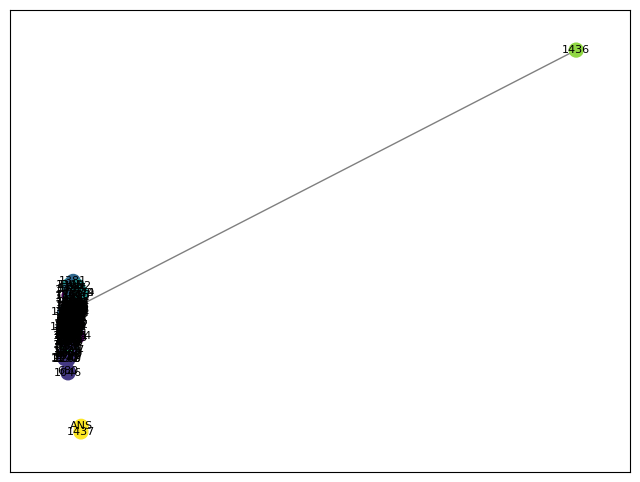

In [22]:
# Set the figure size for a larger plot
plt.figure(figsize=(8, 6))  # Adjust the size as needed

# Draw the graph with communities
pos = nx.spring_layout(G_undirected)
cmap = plt.get_cmap('viridis', max(partition.values()) + 1)

# Draw nodes with the community colors
nx.draw_networkx_nodes(G_undirected, pos, node_size=100, cmap=cmap, node_color=list(partition.values()))  # Increased node_size for better visibility

# Draw edges
nx.draw_networkx_edges(G_undirected, pos, alpha=0.5)

# Draw node labels
nx.draw_networkx_labels(G_undirected, pos, font_size=8, font_color='black')  # Adjust font_size as needed

# Display the plot
plt.show()

c:\Users\LNshuti\AppData\Local\miniconda3\envs\eac-trade\Lib\site-packages\networkx\drawing\layout.py:725: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


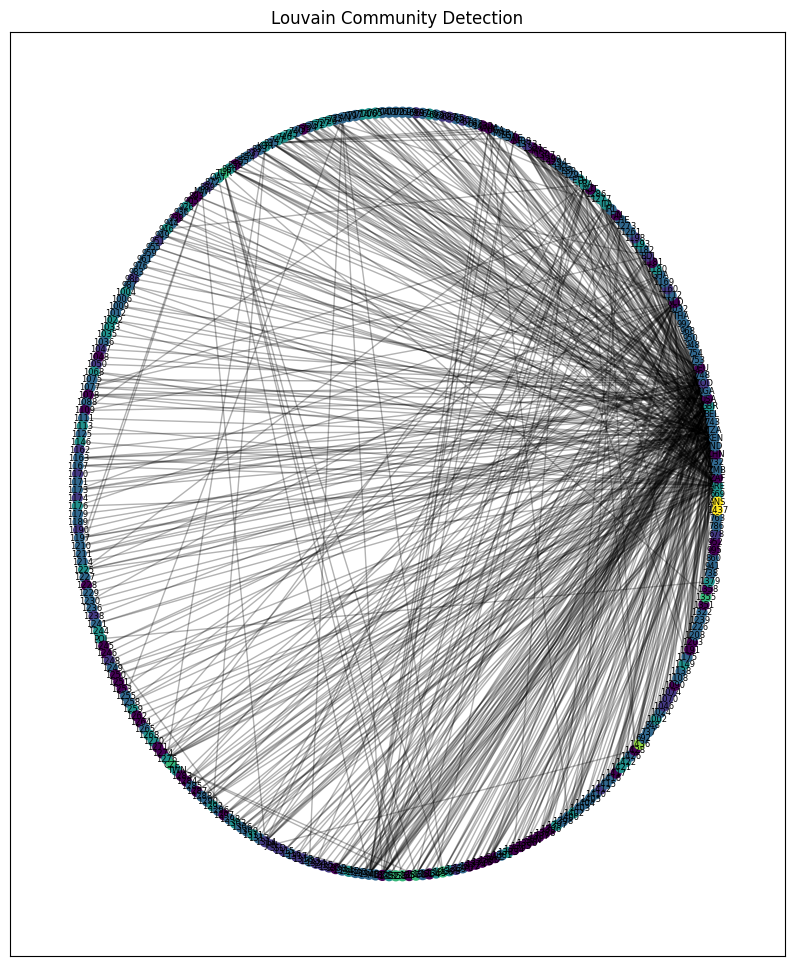

In [23]:
# Set the figure size for a larger plot
plt.figure(figsize=(10, 12))  # Adjust the size as needed

# Use a different layout to reduce overlap
pos = nx.kamada_kawai_layout(G_undirected)

# Get a color map
cmap = plt.get_cmap('viridis', max(partition.values()) + 1)

# Draw nodes with the community colors
nx.draw_networkx_nodes(G_undirected, pos, node_size=50, cmap=cmap, node_color=list(partition.values()))  # Adjusted node_size for better visibility

# Draw edges
nx.draw_networkx_edges(G_undirected, pos, alpha=0.3)

# Draw node labels
nx.draw_networkx_labels(G_undirected, pos, font_size=6, font_color='black')  # Adjust font_size as needed

# Display the plot
plt.title("Louvain Community Detection")
plt.show()

In [27]:
# Function to create a graph for a specific year
def create_year_graph(year):
    G_year = nx.Graph()
    year_data = df_filtered[df_filtered['year'] == year]
    for _, row in year_data.iterrows():
        G_year.add_node(row['product_id'])
        G_year.add_edge(row['product_id'], row['partner_code'], weight=row['import_value'] + row['export_value'])
    return G_year

# Visualize the network dynamics over the years
years = sorted(df_filtered['year'].unique())
for year in years:
    G_year = create_year_graph(year)
    partition = community_louvain.best_partition(G_year)
    pos = nx.spring_layout(G_year)
    cmap = plt.get_cmap('viridis', max(partition.values()) + 1)
    nx.draw_networkx_nodes(G_year, pos, partition.keys(), node_size=40, cmap=cmap, node_color=list(partition.values()))
    nx.draw_networkx_edges(G_year, pos, alpha=0.5)
    plt.title(f'Year: {year}')
    plt.show()

KeyError: 'year'